

```
# This is formatted as code
```

# Part 1: Exploration vs. Exploitation

# RL homework 2

Submitted by: (Salam Qais + 327876116), (Najah Kamal + 325829133)

**Due date: 4 March 2024, 23:55am**

## How to submit

Submissions in pairs only.

You should save a copy of the notebook to Google Drive and open it with Google Colab. Then answer all the questions inside the notebook, at the designated cells. Only the notebook will be submitted in moodle (in `.ipynb` format).

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output).
    
When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'.

Then submit the downloaded '.ipynb' file to Moodle.

# The Assignment

### Part 1: Exploration vs. Exploitation

You will use Python to implement several bandit algorithms.
You will then run these algorithms on a multi-armed Bernoulli bandit problem, to understand the issue of balancing exploration and exploitation.

### Part 2: Model-based RL

You will use Python to implement the Dyna-Q agent with a replay buffer.
You will run the agent on a grid world and analyze the efficieny with respect to the number of steps in the environment.

# Setup

### Import Useful Libraries

In [99]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

<ipython-input-99-b31fed65043d>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


### A generic multi-armed bandit class, with Bernoulli rewards

In [100]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or tf.int32 that specifies which arm to pull.

    Returns:
      A sampled reward according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

### Helper functions

In [101]:
def smooth(array, smoothing_horizon=100., initial_value=0.):
  """smoothing function for plotting"""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot"""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, optimal_value, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 3
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(15, 5*n_rows))

  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)
      #ax.set_axis_bgcolor('white')

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg in current_algs:
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.6, label=alg.name)[0]
        else:
          line = plt.plot(m, alpha=0.6, label=alg.name)[0]
          plt.fill_between(range(number_of_steps), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if not p.log_plot:
        plt.plot([0, number_of_steps], [optimal_value]*2, '--k', label='optimal')

      plt.ylim(p.ylim)
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_bandit_experiment(bandit, algs, repetitions):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}

  for alg in algs:
    reward_dict[alg.name] = []
    action_dict[alg.name] = []

    for _ in range(repetitions):
      alg.reset()
      reward_dict[alg.name].append([])
      action_dict[alg.name].append([])
      action = None
      reward = None
      for i in range(number_of_steps):
        try:
          action = alg.step(action, reward)
        except:
          print(alg, action, reward)
          aoushd()
        reward = bandit.step(action)
        reward_dict[alg.name][-1].append(reward)
        action_dict[alg.name][-1].append(action)

  return reward_dict, action_dict

def train_agents(agents, number_of_arms, number_of_steps, repetitions=30,
                 success_reward=1., fail_reward=0.):

  success_probabilities = np.arange(0.25, 0.75 + 1e-6, 0.5/(number_of_arms - 1))
  bandit = BernoulliBandit(success_probabilities, success_reward, fail_reward)

  max_p = np.max(success_probabilities)
  min_p = np.min(success_probabilities)
  ylim_max = max_p*success_reward + (1 - max_p)*fail_reward
  ylim_min = min_p*success_reward + (1 - min_p)*fail_reward
  dif = ylim_max - ylim_min
  ylim = (ylim_min - 0.1*dif, ylim_max + 0.1*dif)

  max_prob = np.max(success_probabilities)
  optimal_value = max_prob*success_reward + (1 - max_prob)*fail_reward

  reward_dict, action_dict = run_bandit_experiment(bandit, agents, repetitions)

  smoothed_rewards = {}
  expected_rewards = {}
  regrets = {}
  for agent, rewards in reward_dict.items():
    smoothed_rewards[agent] = np.array(rewards)
  for agent, actions in action_dict.items():
    p_success = one_hot(actions, number_of_arms).dot(success_probabilities)
    expected_rewards[agent] = p_success*success_reward + (1 - p_success)*fail_reward
    regrets[agent] = optimal_value - expected_rewards[agent]

  PlotData = namedtuple('PlotData', ['title', 'data', 'log_plot', 'ylim'])
  plot_data = [
      PlotData(title='Smoohted rewards', data=smoothed_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Expected rewards', data=expected_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Current Regret', data=regrets,
               log_plot=True, ylim=(1e-2, 1)),
      PlotData(title='Total Regret',
               data=dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()]),
               log_plot=False, ylim=(1e-0, 5e2)),
  ]

  plot(agents, plot_data, optimal_value)

### Random agent

In [102]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms',
  uniformly at random. The 'previous_action' argument of 'step'
  is ignored.
  """

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'random'
    self.reset()

  def step(self, previous_action, reward):
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass

# A1: Implement agents

Each agent, should implement the following methods:

### `step(self, previous_action, reward)`:
should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

### `reset(self)`:
resets statistics (should be equivalent to constructing a new agent from scratch).  
**Note:** Make sure that the initial values (after a reset) are all zero.

### `__init__(self)`:
The `__init__` can be *the same* as for the random agent above (with the exception of $\epsilon$-greedy---see below), except for the name, which should be unique (e.g., 'greedy', 'ucb', etc.)

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.



## Agent 1: greedy
**[5 pts]** You should **implement the greedy** agent, that

1.   Estimates the average reward for each action that was selected so far, and
2.   Always selects the highest-valued action.


In [103]:

class Greedy(object):
    def __init__(self, number_of_arms):
        self._number_of_arms = number_of_arms
        #self.Qt_a = np.zeros(number_of_arms)
        #self.Nt_a = np.zeros(number_of_arms)
        self.name = 'Greedy'
        self.reset()


    def reset(self):
        self.Qt_a = np.zeros(self._number_of_arms)
        self.Nt_a = np.zeros(self._number_of_arms)

    def step(self, previous_action, reward):

        if previous_action is  None:
          return np.random.randint(self._number_of_arms)
        self.Nt_a[previous_action] += 1
        self.Qt_a[previous_action] += (reward - self.Qt_a[previous_action]) / self.Nt_a[previous_action]
        action = np.argmax(self.Qt_a)

        return action


## Agent 2: $\epsilon$-greedy
**[5 pts]** You should **implement an $\epsilon$-greedy** agent, that selects the highest-valued action with probability $1 - \epsilon$, and otherwise selects an action at random.

The exploration parameter $\epsilon$ should be given in the `__init__`, as indicated in the code below.


In [104]:

class EpsilonGreedy(object):
    def __init__(self, number_of_arms, epsilon=0.1):
        self._number_of_arms = number_of_arms
        self._epsilon = epsilon
       # self.Qt_a = np.zeros(number_of_arms)
       # self.Nt_a = np.zeros(number_of_arms)
        self.name = 'Epsilon-greedy epsilon:{}'.format(epsilon)
        self.reset()


    def reset(self):
        self.Qt_a = np.zeros(self._number_of_arms)
        self.Nt_a = np.zeros(self._number_of_arms)


    def step(self, previous_action, reward):
        if previous_action is  None:
                return np.random.randint(self._number_of_arms)

        self.Nt_a[previous_action] += 1
        self.Qt_a[previous_action] += (reward - self.Qt_a[previous_action]) / self.Nt_a[previous_action]

        if np.random.rand() < self._epsilon:         # 1-epsioln chooses random
            action = np.random.choice(self._number_of_arms)
        else:
            action = np.argmax(self.Qt_a)        # epsioln chooses max
        return action



## Agent 3: UCB
**[10 pt]** You should **implement** an agent that **explores with UCB**.


In [105]:

class UCB(object):
    def __init__(self, number_of_arms):
        self._number_of_arms = number_of_arms
        #self.Qt_a = np.zeros(number_of_arms)
        #self.Nt_a = np.zeros(number_of_arms)
        self.name = 'UCB'
        #self.t = 0
        self.reset()


    def reset(self):
        self.Qt_a = np.zeros(self._number_of_arms)
        self.Nt_a = np.zeros(self._number_of_arms)
        self.t = 0

    def step(self, previous_action, reward):
        self.t += 1
        if previous_action is None :
                return np.random.randint(self._number_of_arms)

        self.Nt_a[previous_action] += 1
        self.Qt_a[previous_action] += (reward - self.Qt_a[previous_action]) / self.Nt_a[previous_action]
        Ut_a = np.sqrt(2 * np.log(self.t) / (self.Nt_a ))
        action = np.argmax(self.Qt_a + Ut_a)
        return action



## Agent 4: REINFORCE agents
You should implement agents that implement REINFORCE policy-gradient methods. We went over REINFORCE in the context of full MDPs, but it can also be implemented in a multi-armed bandit setup.  

The policy should be parameterized using action preferenes $p$, using a softmax on top:
$$\pi(a) = \frac{\exp(p(a))}{\sum_b \exp(p(b))}\,.$$

The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.



## Assignment 4a:
In the next text field, write down the update function to the preferences for all actions $\{a_1, \ldots, a_n\}$ if you selected a specific action $A_t = a_i$ and received a reward of $R_t$.

In other words, complete:
\begin{align*}
p_{t+1}(a)
& = \ldots
&& \text{for $a = A_t$} \\
p_{t+1}(b)
& = \ldots
&& \text{for all $b \ne A_t$}
\end{align*}

**[10 pts]** **Instructions**: please provide answer in markdown/latex below.
\begin{align*}
Δϴ_{t+1}(a)=a\triangledown_{ϴ}logπ_{θ}(s,a) v_{t}\\
ϴ_{t+1}(a)-ϴ_{t}(a)=a\triangledown_{ϴ}logπ_{θ}(s,a) v_{t}\\
\end{align*}
In our case
\begin{align*}
p_{t+1}(a)-p_{t}(a)=\triangledown_{p(a)}logπ_{p(a)}(s,a) v_{t}\\
p_{t+1}(a)=p_{t}(a)+\triangledown_{p(a)}logπ_{p(a)}(a) v_{t}\\
\end{align*}
Lets calculate in two steps

step 1)
\begin{align*}
logπ_{p(a)}(a)=log\frac{ e^{p(a)}}{Σ_{b}e^{p(b)}} =loge^{p(a)}-log(Σ_{b}e^{p(b)})\\=p(a)-log(Σ_{b}e^{p(b)})
\end{align*}
step 2)
\begin{align*}
\triangledown_{p(a)}logπ_{p(a)}=
\triangledown_{p(a)}(p(a)-log(Σ_{b}e^{p(b)}))=1-\frac{ e^{p(a)}}{Σ_{b}e^{p(b)}}=1-π(a)    
 && \text{for all $a = A_t$}\\
 \triangledown_{p(b)}logπ_{p(b)}=-π(b)    
 && \text{for all $b \ne A_t$}
\end{align*}
so the law is
\begin{align*}
p_{t+1}(a)=p_{t}(a)+a(1-π(a) )v_{t}
 && \text{for all $a = A_t$}\\
p_{t+1}(b)=p_{t}(b)+a(-π(b) )v_{t}
 && \text{for all $b \ne A_t$}
\end{align*}









## Assignment 4b:
**[10 pts]** You should implement a **vanilla REINFORCE** agent **with** and **without** a **baseline**. Implement the baseline as a state value (rembember the baseline should be independent of actions).

Whether or not a baseline is used should be a boolean constructor argument.

In [106]:
class REINFORCE(object):

  def __init__(self, number_of_arms, step_size=0.1, baseline=False):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self.name = 'REINFORCE, baseline: {}'.format(baseline)
    self._baseline = baseline
    self.reset()

  def reset(self):
    self.p_a = np.zeros(self._number_of_arms)
    self.curr_num_actions = 0
    self._total= 0.0


  def step(self, previous_action, reward):
    if(previous_action is None):
      return np.random.randint(self._number_of_arms)

    a=self._lr
    self._total += reward
    self.curr_num_actions += 1
    base_line = self._total / self.curr_num_actions
    Rt=reward
    if(self._baseline):
      Rt = reward - base_line
    sigma=  np.sum(np.exp(self.p_a))
    pai_list = np.exp(self.p_a) / sigma

    for idx in range(self._number_of_arms):
      if(idx == previous_action):
        self.p_a[idx] = self.p_a[idx] + a * (1 - pai_list[idx]) * Rt
      else:
        self.p_a[idx] = self.p_a[idx] - a * (pai_list[idx]) * Rt

    updated_sigma = np.sum(np.exp(self.p_a))
    updated_pai_list = np.exp(self.p_a) / updated_sigma
    action = np.random.choice(self._number_of_arms, p=updated_pai_list)
    return action



# Assignment 5: Analyse Results

### Run the cell below to train the agents and generate the plots for the first experiment.

> Indented block



Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

<ipython-input-105-f1a2780014d3>:23: RuntimeWarning: divide by zero encountered in divide
  Ut_a = np.sqrt(2 * np.log(self.t) / (self.Nt_a ))


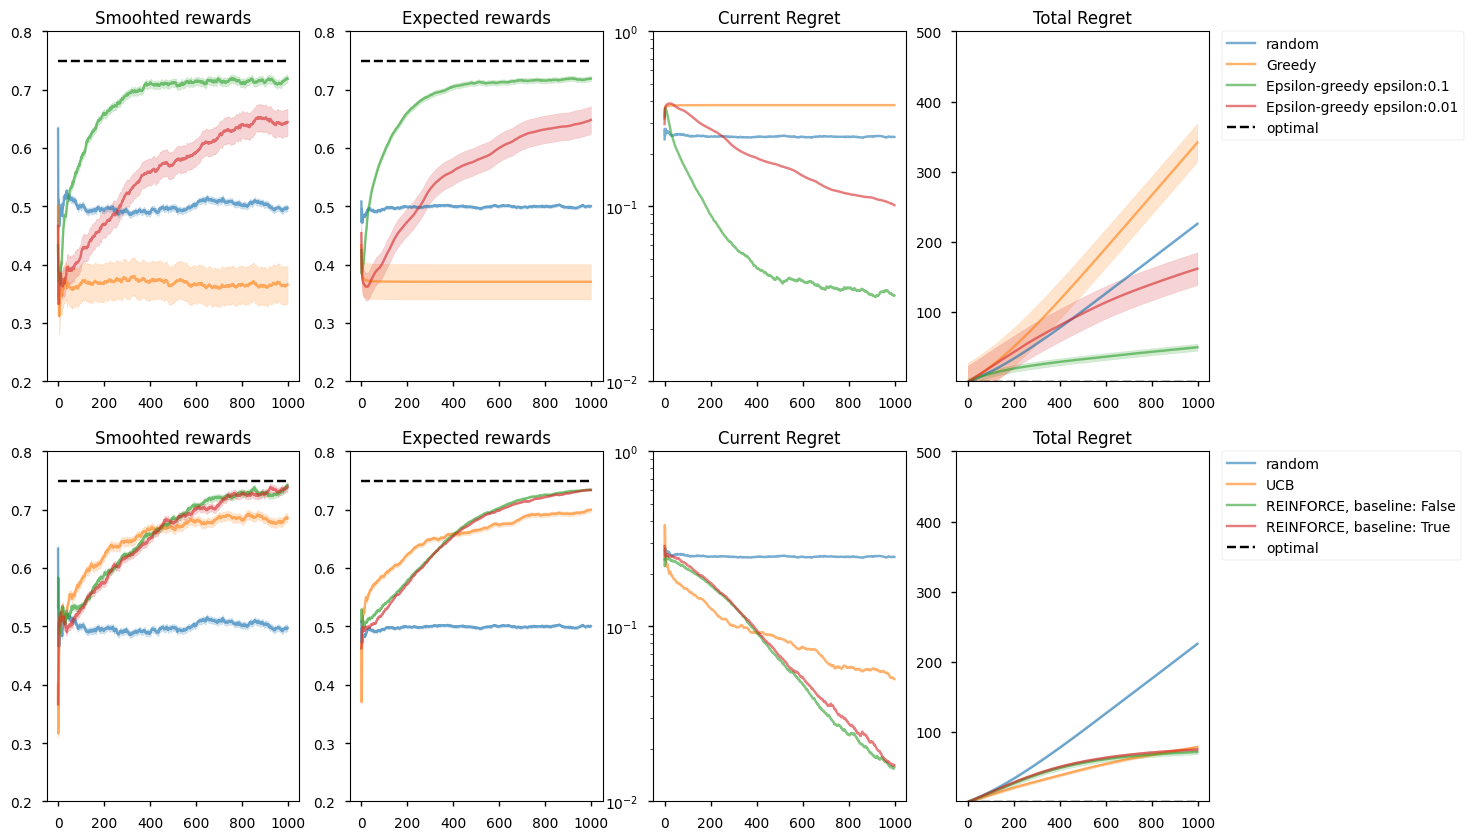

In [107]:
#@title Experiment 1: Bernoulli bandit

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(number_of_arms),
    Greedy(number_of_arms),
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

## Assignment 5 a.
(Answer inline in the markdown below each question.)

**[5pts]** Name the best and worst algorithms, and explain (with one or two sentences each) why these are best and worst.

***The answer:**

- The best algorithm is Reinforce, in the two cases with basline or not, but with baseline seems to be better a little bit (it is not obvious). It is because in this algorithm we use policy gradient theorem, and we update the parameters using stochastic gradient ascent, this enables us to direct our behaviour and our policy in the direction that we know because of the direction of the gradient. In addition, by using baseline we reuduce the variance. This conclusion is seen in the graphs- we can see that the rewards are the highest in this algorithm and the total and current regret are approxiamtely the lowest.
- The worst algorithm is the Greedy algorithm. This is because the greedy algorithm selects the action with the highest value, so it can lock onto a suboptimal action forever. In other words, it doesn't explore actions and it may stuck in local maximum value and not global. As we see it lacks the explorition feature. And we can see that from the results in the graphs, that the rewards are the lowest and the current and total regret is the highest.*  

**[5pts]** Which algorithms are guaranteed to have linear total regret?

**The answer:**

Many algorithms have linear total regret, such as: The Greedy, the ϵ-greedy, and the greedy + optimistic initialisation and the ϵ-greedy + optimistic initialisation have linear total regret, as we have seen in the lecture (and we can see in the graphs of the greedy and ϵ-greedy). Also the random algorithm has linera total regret, as we can see in the graph.

**[5pts]** Which algorithms are guaranteed to have logarithmic total regret?

**The answer:**

The UCB algorithm has logarithmic total regret aas we have seen in the lecture, also it can be seen in the graph. In addition, as we have seen in the lecture Decaying ϵ_t has logarithmic asymptotic total regret. Moreover, as we can see in the graph the Reinforce alogrithm (with baseline or not) has a logarithmic total regret.

**[5pts]** Which of the $\epsilon$-greedy algorithms performs best?  Which should perform best in the long run?

**The answer:**

The algorithm when ϵ=0.1 is better than the algorithm when ϵ=0.01. It can be seen in the graphs, that from the beginning the reward are higher, and the current regret is lower, also the total regret is lower. Ie is because when ϵ=0.1 we explore more.

However, in the long run we prefer to use ϵ=0.01, as we see in the graphs the rewards for ϵ=0.01 at the end is much more higher or the same as when ϵ=0.1, also the current regret is much lower at the end when ϵ=0.01, and the total regret when ϵ=0.01 at the end has a less tendency. It is because afte a certain amount of time we don't want to explore more, we have a picture of the world and an assessment of it, so we want to exploit more thant explore.


### Run the cell below to train the agents and generate the plots for the second experiment.

Trains the agents on a bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

<ipython-input-105-f1a2780014d3>:23: RuntimeWarning: divide by zero encountered in divide
  Ut_a = np.sqrt(2 * np.log(self.t) / (self.Nt_a ))


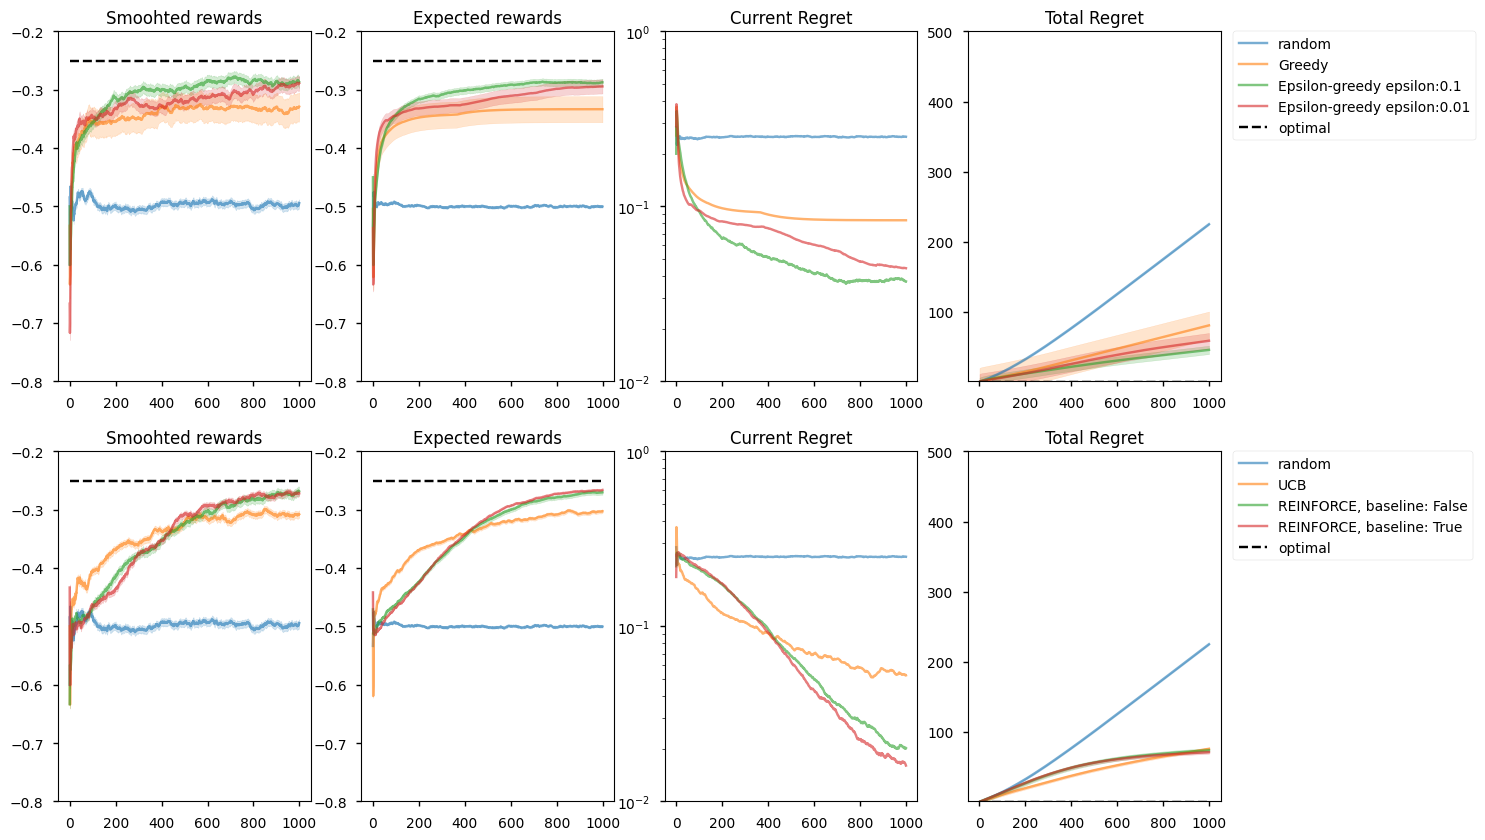

In [108]:
#@title Experiment 2: R = 0 on success, R = -1 on failure.
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

## Assignment 5 b.
(Answer inline in markdown.)

**[10pts]** Explain which algorithms improved from the changed rewards, and why.

(Use at most two sentences per algorithm and feel free to combine explanations for different algorithms where possible).

**The answer:**

As we can see the Greedy algorithm has improved the most due to the changes in the rewards. Before the changes the Greedy algorithm was the worst (it had the lowest reward and the highest regret), and after the changes it can be seen clearly that the graphs of the Greedy algorithm, the reward function now is to high and it is close to the ϵ-greedy methods, and the total regret functions now it is much lower and it is very close to the ϵ-greedy total regret function, and the current regret function is much lower.

In addition, the ϵ-greedy algorithms has improved and it can be see in the graphs, and it is seen that in the beginning of the episdoe the grpahs improve quickly, for example the rewards graphs. And we can see that the ϵ-greedy when ϵ=0.01 has improved much better than the improvment when ϵ=0.1.

In conclusion, the main chnge that has happend after the changes in the rewards has happend in the greedy functions (including the ϵ-greedy). The reason of that is that in the greedy methods, we choose the actions with the highest value, therefore we may stuck in local maximum, and we will not change our decisions because we don't loose anything by choosing the action with the highest value. However, if we get a reward of -1 in failure, it means we are loosing and the value function is decreasing, the value function for the action with the highest value may decrease (if it is not the best action to do in the global world), therefore the action that we have always chose we may not choose because now it doesn't have the highest value.

The reason of why the biggest improvment is seen in the greedy method more than the ϵ-greedy, and when ϵ=0.01 more than when ϵ=0.1, is that in the greedy method we always choose the action with the highest value and we don't explore and do other actions, so now when the value of the highest value action will decrease, we will choose another action, and we will explore more. And when ϵ us bigger we explore more, so we don't need that much the decrement to explore.

Of course, some other algorithms have improved, but it is not clear and ism=n't worth mentioning.


# Part 2: Model-based RL

### A grid world

In [109]:
class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0, 10,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(8, 3, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = 0.9
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)

    self._state = new_state

    return reward, discount, self.get_obs()

### Helper functions

In [110]:
def run_experiment(env, agent, number_of_steps):
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)

def random_policy(q):
  return np.random.randint(4)

def plot_values(values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])


## Dyna-Q with experience replay

**[20 pts]** Since the environment is a simple deterministic grid world, we will implement the model as an **Experience Replay Buffer**. This means we will store every transition $(S, A, R, \gamma, S')$ from the real environment in the buffer, and then extract random transitions to train the agent. The reason this can be considered a model is that the transitions in the replay buffer serve as a mapping from $(S, A)$ pairs to the values of $(R, \gamma, S')$. The reason we store $\gamma$ is to detect the goal state (see below).

More precisely, to learn action values, at each step:
* select actions according to the behaviour policy
* accumulate all observed transitions $(S, A, R, \gamma, S')$  in the environment in a *replay buffer*,
* apply an online Q-learning
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

In pseudo-code:

**Initialize** $Q(s, a)$, and $\text{ReplayBuffer}$

**Loop**:

1. $S \gets{}$current (nonterminal) state

2. $A \gets{} $sample action from behaviour policy

3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A, R, \gamma, S')$

6. repeat n times:

  1. $S, A, R, \gamma, S' \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

### A note on the behaviour policy
Assume a behaviour policy object is given in the constructor which can be used to sample actions given the Q values. So you can use it as follows:
```
action = self._behaviour_policy(self._q_values[next_state])
```

### A note on the discount factor
When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.


### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  As in the previous assignment you can use the action `0` (which corresponds to `up`) as initial action, so that otherwise we do not have to worry about this.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Q-learning and it's variants needs to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._action = 0
  (...)
```


In [111]:

class DynaQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state,  behaviour_policy, num_offline_updates=0, step_size=0.1):
    self.number_of_states = number_of_states
    self.number_of_actions = number_of_actions
    self.initial_state = initial_state
    self.behaviour_policy = behaviour_policy
    self.num_offline_updates = num_offline_updates
    self.step_size = step_size
    self._q_values = np.zeros((number_of_states, number_of_actions))
    self.replay_buffer = {}
    self.prev_state = initial_state
    self.prev_action = None
    return

  @property
  def q_values(self):
    return self._q_values

  def initial_action(self):
    self.prev_action = 0
    return self.prev_action


  def step(self, reward, discount, next_state):
    action = self.behaviour_policy(self._q_values[next_state])

    a = self.step_size
    Qs_a = self._q_values[self.prev_state, self.prev_action]

    max_a = np.max(self._q_values[next_state])
    self._q_values[self.prev_state, self.prev_action] += a * (reward + discount * max_a - Qs_a)
    self.replay_buffer[self.prev_state ,self.prev_action] = (reward, discount, next_state)

    for  index in range(self.num_offline_updates):
      labels_state_action = list(self.replay_buffer.keys())
      random_s_a = np.random.randint(len(labels_state_action))
      random_state, random_action = labels_state_action[random_s_a]
      _reward_b, _discount_b, _next_state_b = self.replay_buffer[(random_state, random_action)]
      self._q_values[random_state, random_action] += a * (_reward_b + _discount_b * np.max(self._q_values[_next_state_b]) - self._q_values[random_state, random_action])

    self.prev_state = next_state
    self.prev_action = action


    return action


## Analyse results.

We will compare the performance of vanilla Q-learning and DynaQ with 100 of offline updates per setp (updates from the replay buffer).

Vanilla Q-learning can be implemented by setting the number of offline updates to zero.

Run the following cell and answer the question.


Q-learning value at init state 0.0
dyna-Q value at init state 4.304672099999971


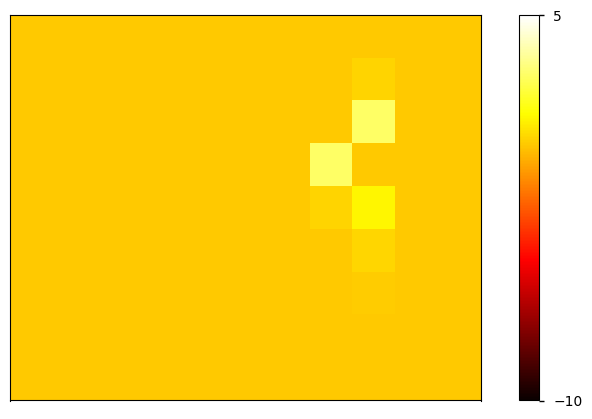

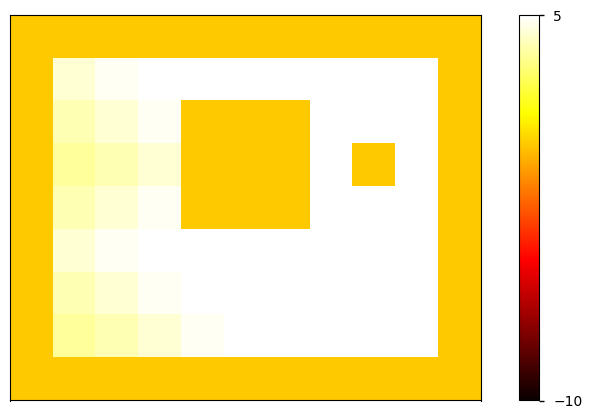

In [112]:
# start environment
grid = Grid()
init_state = grid.get_obs()

behaviour_policy = random_policy # uniform random that does not depend on Q

# start agents
agents = [
    DynaQ(grid._layout.size, 4, grid.get_obs(),
                behaviour_policy, num_offline_updates=0, step_size=0.1),
    DynaQ(grid._layout.size, 4, grid.get_obs(),
                behaviour_policy, num_offline_updates=100, step_size=0.1),
]

agent_names = ["Q-learning", "dyna-Q"]

for a in range(len(agents)):
  # restart environment
  grid = Grid()

  # run expriments and get Q-values.
  run_experiment(grid, agents[a], int(1e3))

  # compute the one-step greedy state values
  v = np.max(agents[a].q_values, axis=1)

  # show results
  plt.figure(figsize=(10,5))
  plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
  print(agent_names[a], 'value at init state', v[init_state])

**[10 pts]** Explain the difference between the two runs.

(Answer inline in markdown).

*The first run approximately  didnt provide anything it didnt find path from the initial  state or from other states. However, the seconed run succeeded  in finding a paths from most of  the states

This occur because The First run have num_offline_updates=0, this means that the agent update its Q-values according to real experience and it didnt use any simulated experience and doesn't sample anything from our model, this means it struggles to explore and find paths. But in the seconed run we have  num_offline_updates=100, So the agent now learn from the real experience like the first run but it also learn and plan from the simulated experience and by sampling from our model to learn the value function or the policy from them. So it can explore more paths
.*